In [1]:

from pathlib import Path
import os
import pprint
import pandas as pd
import pygwalker as pyg
import dabl

import sys
from pathlib import Path
#### For Path setup
def setup_project_path():
    """프로젝트 루트 경로를 찾아서 파이썬 경로에 추가"""
    current = Path.cwd()
    while current != current.parent:
        if (current / '.git').exists():
            if str(current) not in sys.path:
                sys.path.append(str(current))
                print(f'Project root found: {current}')
            return current
        current = current.parent
    return None

# 프로젝트 경로 설정
project_root = setup_project_path()
if project_root is None:
    # 프로젝트 루트를 찾지 못했다면 직접 지정
    project_root = Path("D:/dev/upstageailab5-ml-regression-ml_r4")
    if str(project_root) not in sys.path:
        sys.path.append(str(project_root))

#jupyter nbextension enable --py widgetsnbextension

Project root found: d:\dev\upstageailab5-ml-regression-ml_r4


# Fater EDA DataPrep


In [ ]:
import pandas as pd
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.feature_selection import mutual_info_regression
import numpy as np
from scipy.stats import entropy
from tqdm import tqdm

import pandas as pd
from scipy.stats import entropy
# 숫자형 데이터에 대해 변환
from sklearn.preprocessing import RobustScaler, PowerTransformer

def classify_columns(df, unique_threshold=10, freq_threshold=0.8, entropy_threshold=1.0):
    numeric_cols = []
    categorical_cols = []

    for col in df.columns:
        # Check if column is numeric
        if pd.api.types.is_numeric_dtype(df[col]):
            unique_values = df[col].nunique()
            value_counts = df[col].value_counts(normalize=True)
            col_entropy = entropy(value_counts)

            # Classification logic
            if unique_values <= unique_threshold:
                categorical_cols.append(col)
            elif any(value_counts > freq_threshold):
                categorical_cols.append(col)
            elif col_entropy < entropy_threshold:
                categorical_cols.append(col)
            else:
                numeric_cols.append(col)
        else:
            categorical_cols.append(col)
    print(f'Numeric columns:{len(numeric_cols)} \n{numeric_cols}')
    print(f'Categorical columns:{len(categorical_cols)} \n{categorical_cols}')

    return numeric_cols, categorical_cols

@Utils.timeit
def calculate_correlation(df, corr_threshold=0.9):
    """
    Identifies groups of correlated features based on a specified threshold.
    """
    print(f'Calculating correlation with threshold: {corr_threshold}')
    
    # 숫자형 컬럼만 선택
    numeric_df = df.select_dtypes(include='number')
    
    # 상관관계 계산
    corr_matrix = numeric_df.corr().abs()
    correlated_groups = {}

    # NaN 값 처리
    corr_matrix = corr_matrix.fillna(0)

    for i in tqdm(range(len(corr_matrix.columns))):
        for j in range(i):
            if corr_matrix.iloc[i, j] > corr_threshold:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                if col1 not in correlated_groups:
                    correlated_groups[col1] = {col1}
                correlated_groups[col1].add(col2)
    print(f'Found {len(correlated_groups)} groups of correlated features.\n{correlated_groups}')
    return correlated_groups

@Utils.timeit
def select_important_features(df, correlated_groups):
    """
    Selects the most important feature from correlated groups based on mutual information.
    """
    print(f'Selecting important features from {len(correlated_groups)} groups')
    selected_features = set()
    numeric_cols = df.select_dtypes(include='number').columns

    # 타겟 변수 선택 (첫 번째 컬럼 대신 특정 컬럼 지정)
    target_col = numeric_cols[0]  # 또는 특정 컬럼 지정
    
    # Calculate feature importance
    importance_scores = {}
    for col in tqdm(numeric_cols):
        if col == target_col:
            continue
        try:
            # NaN 값 처리
            X = df[[col]].fillna(df[col].mean())
            y = df[target_col].fillna(df[target_col].mean())
            importance_scores[col] = mutual_info_regression(X, y)[0]
        except Exception as e:
            print(f"Warning: Failed to calculate importance for '{col}': {str(e)}")
            importance_scores[col] = 0

    # Select features
    for group in tqdm(correlated_groups.values()):
        group = list(group)
        group = sorted(group, key=lambda x: importance_scores.get(x, 0), reverse=True)
        if group:  # 그룹이 비어있지 않은 경우만
            selected_features.add(group[0])

    # Add uncorrelated features
    uncorrelated_features = set(numeric_cols) - {item for group in correlated_groups.values() for item in group}
    selected_features.update(uncorrelated_features)
    print(f'Found {len(uncorrelated_features)} uncorrelated features: {uncorrelated_features}')
    return list(selected_features)

from sklearn.model_selection import train_test_split
@Utils.timeit
def preprocess_and_select(train_df, test_df, target_col, corr_threshold=0.9):
    """
    학습 데이터와 실제 테스트 데이터를 함께 전처리
    
    Parameters:
    -----------
    train_df: 학습용 데이터 (정답 있음)
    test_df: 실제 테스트 데이터 (정답 없음)
    """
    # 1. 학습 데이터에서 타겟 분리
    y_train = train_df[target_col]
    X_train = train_df.drop(columns=[target_col])
    
    # 2. 전체 데이터 결합 (스케일링용)
    all_data = pd.concat([X_train, test_df], axis=0)
    print(f"Combined data shape: {all_data.shape}")
    
    # 3. 수치형/범주형 컬럼 분류
    numeric_cols, categorical_cols = classify_columns(all_data)
    
    # 4. 전체 데이터 스케일링
    scaled_data = all_data.copy()
    scaler_dict = {}
    
    for col in numeric_cols:
        if col == target_col:
            continue
            
        try:
            if '좌표' in col or col == '건축년도':
                scaler = RobustScaler()
            else:
                scaler = PowerTransformer(method='yeo-johnson')
                
            scaled_data[col] = scaler.fit_transform(all_data[[col]])
            scaler_dict[col] = scaler
        except Exception as e:
            print(f"Warning: Failed to transform '{col}': {str(e)}")
            scaler = RobustScaler()
            scaled_data[col] = scaler.fit_transform(all_data[[col]])
            scaler_dict[col] = scaler
    
    # 5. 스케일링된 데이터 다시 분리
    X_train_scaled = scaled_data.iloc[:len(X_train)]
    X_test_scaled = scaled_data.iloc[len(X_train):]
    
    # 6. 상관관계 및 특성 선택 (학습 데이터만 사용)
    correlated_groups = calculate_correlation(X_train_scaled, corr_threshold)
    selected_features = select_important_features(X_train_scaled, correlated_groups)
    
    print(f"Selected features: {len(selected_features)}")
    print(f"Train shape: {X_train_scaled[selected_features].shape}")
    print(f"Test shape: {X_test_scaled[selected_features].shape}")
    
    return (X_train_scaled[selected_features], y_train, 
            X_test_scaled[selected_features], 
            selected_features, scaler_dict)

2024-11-08 18:46:04,754 - root - INFO - Initialized Logger.
2024-11-08 18:46:04,756 - root - INFO - Windows platform. Font: ['Malgun Gothic']


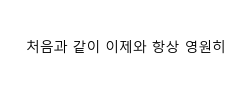

2024-11-08 18:46:07,827 - root - INFO - #### Current workspalce: d:\dev\upstageailab5-ml-regression-ml_r4
2024-11-08 18:46:07,828 - root - INFO - Windows platform. Path: D:\dev\upstageailab5-ml-regression-ml_r4
2024-11-08 18:46:07,831 - root - INFO - #### Init Data Prep.. 


<Figure size 640x480 with 0 Axes>

In [3]:
from src.logger import Logger
from src.preprocessing import DataPrep
from src.eda import EDA
from src.feature import FeatureEngineer, Clustering, XAI
from src.train import Model
from src.visualization import Visualizer
from src.utils import Utils, PathManager
## memory management
import gc
gc.collect()
########################################################################################################################################
logger_instance = Logger()
logger = logger_instance.logger
utils = Utils(logger)
utils.setup_font_and_path_platform()
current_platform = utils.current_platform
#os.environ['PYTHONPATH'] = r'D:\dev\upstageailab5-ml-regression-ml_r4'
current_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
logger.info(f'#### Current workspalce: {current_path}')
if current_platform == 'Windows':
    base_path = Path(r'D:\dev\upstageailab5-ml-regression-ml_r4')
    logger.info(f'{current_platform} platform. Path: {base_path}')
elif current_platform == 'Darwin':          # Mac
    base_path = Path('/data/ephemeral/home/dev/upstageailab5-ml-regression-ml_r4')
    logger.info(f'{current_platform} platform. Path: {base_path}')
else:
    base_path = Path('/data/ephemeral/home/dev/upstageailab5-ml-regression-ml_r4')    # Linux
    logger.info(f'{current_platform} platform. Path: {base_path}')
########################################################################################################################################
out_path = os.path.join(base_path,'output')
config ={   
        'out_path':out_path,
        'base_path':base_path,
        'subway_feature': os.path.join(base_path, 'data','subway_feature.csv'),
        'bus_feature': os.path.join(base_path, 'data','bus_feature.csv'),
        'logger': logger_instance,#logger,
        'random_seed': 2024,
        'target': 'target',
        'thr_ratio_outlier': 0.01,
        'thr_ratio_null': 0.9,
        'wandb': {
            'project': 'project-regression_house_price',     # 필수: wandb 프로젝트명
            'entity': 'joon',          # 필수: wandb 사용자/조직명
            'group': 'group-ml4',    # 선택: 실험 그룹명
        }
    }

########################################################################################################################################
### Data Prep
prep_path = os.path.join(base_path, 'data', 'processed')
path_baseline = os.path.join(prep_path, 'df_baseline_prep.csv')
path_auto = os.path.join(prep_path, 'df_auto_prep.csv')
########################################################################################################################################
### EDA

path_feat = os.path.join(prep_path, 'df_feat.csv')
path_feat_add = os.path.join(prep_path, 'df_feat_add.csv')

data_prep = DataPrep(config)

In [14]:
import pandas as pd
from scipy.stats import entropy
# 숫자형 데이터에 대해 변환
from sklearn.preprocessing import RobustScaler, PowerTransformer

def classify_columns(df, unique_threshold=10, freq_threshold=0.8, entropy_threshold=1.0):
    numeric_cols = []
    categorical_cols = []

    for col in df.columns:
        # Check if column is numeric
        if pd.api.types.is_numeric_dtype(df[col]):
            unique_values = df[col].nunique()
            value_counts = df[col].value_counts(normalize=True)
            col_entropy = entropy(value_counts)

            # Classification logic
            if unique_values <= unique_threshold:
                categorical_cols.append(col)
            elif any(value_counts > freq_threshold):
                categorical_cols.append(col)
            elif col_entropy < entropy_threshold:
                categorical_cols.append(col)
            else:
                numeric_cols.append(col)
        else:
            categorical_cols.append(col)
    print(f'Numeric columns:{len(numeric_cols)} \n{numeric_cols}')
    print(f'Categorical columns:{len(categorical_cols)} \n{categorical_cols}')

    return numeric_cols, categorical_cols




In [3]:
pm = PathManager(base_path)
pm.get_all_paths()

    
# # 기본 경로 생성
# paths = pm.add_paths({
#     'logs': 'logs',
#     'config': 'config',
#     'output': 'output',
#     'data': 'data'
# })

# # 하위 디렉토리 생성
# model_path = pm.create_subdir('output', 'models')
# cache_path = pm.create_subdir('data', 'cache')

# # 경로 사용
# log_path = pm.get_path('logs')
# config_path = pm.get_path('config')


{}

In [7]:
list_csv = Utils.list_files(prep_path, '.csv')
#pprint.pprint(list_csv)

df= pd.read_csv(list_csv[6])
df.head()
df.columns
df = utils.remove_unnamed_columns(df)
df.columns


2024-11-08 17:50:23,358 - root - INFO - Removing unnamed columns: ['Unnamed: 0']


Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-홈페이지', 'k-수정일자',
       '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y',
       '단지신청일', 'target', '구', '동', '계약년', '계약월', '강남여부', '신축여부', 'is_test',
       'subway_station_area_count', 'subway_direct_influence_count',
       'subway_indirect_influence_count', 'subway_shortest_distance',
       'subway_zone_type', 'bus_station_area_count',
       'bus_direct_influence_count', 'bus_indirect_influence_count',
       'bus_shortest_distance', 'bus_zone_type', 'cluster_dist',
       'cluster_dist_count', 'cluster_dist_transport',
       'cluster_dist_transport_count

In [15]:
numeric_cols, categorical_cols = classify_columns(df)


Numeric columns:42 
['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', 'k-전화번호', 'k-팩스번호', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '건축면적', '주차대수', '단지승인일', '좌표X', '좌표Y', '단지신청일', 'target', '구', '동', '계약년', '계약월', 'subway_indirect_influence_count', 'subway_shortest_distance', 'bus_station_area_count', 'bus_direct_influence_count', 'bus_indirect_influence_count', 'bus_shortest_distance', 'cluster_dist_transport', 'cluster_dist_transport_count']
Categorical columns:22 
['k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-홈페이지', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '관리비 업로드', '강남여부', '신축여부', 'is_test', 'subway_station_area_count', 'subway_direct_influence_count', 'subway_zone_type', 'bus_zone_type', 'cluster_dist', 'cluster_dist_count']


In [18]:
import pandas as pd
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.feature_selection import mutual_info_regression
import numpy as np
from scipy.stats import entropy
from tqdm import tqdm

@Utils.timeit
def scale_numeric_features(df):
    """
    Applies Yeo-Johnson or Box-Cox transform based on the values.
    Includes error handling and fallback to RobustScaler.
    """
    print('Scaling numeric features')
    transformed_df = df.copy()
    
    for col in tqdm(df.select_dtypes(include='number').columns):
        try:
            # 상수값 체크
            if df[col].nunique() == 1:
                print(f"Warning: Column '{col}' has constant values. Skipping transformation.")
                continue
                
            # 0이나 음수가 있는지 체크
            if (df[col] > 0).all():
                transformer = PowerTransformer(method='box-cox', standardize=True)
            else:
                transformer = PowerTransformer(method='yeo-johnson', standardize=True)
            
            # 이상치나 무한값 처리
            data = df[[col]].replace([np.inf, -np.inf], np.nan).dropna()
            if len(data) == 0:
                print(f"Warning: Column '{col}' has no valid data after cleaning. Skipping transformation.")
                continue
                
            # 변환 시도
            transformed_values = transformer.fit_transform(data)
            transformed_df.loc[data.index, col] = transformed_values
            
        except Exception as e:
            print(f"Warning: Failed to transform '{col}' using PowerTransformer: {str(e)}")
            print(f"Falling back to RobustScaler for '{col}'")
            try:
                # RobustScaler로 대체
                scaler = RobustScaler()
                transformed_df[col] = scaler.fit_transform(df[[col]])
            except Exception as e2:
                print(f"Warning: Failed to scale '{col}' using RobustScaler: {str(e2)}")
                print(f"Keeping original values for '{col}'")
    
    return transformed_df

@Utils.timeit
def calculate_correlation(df, corr_threshold=0.9):
    """
    Identifies groups of correlated features based on a specified threshold.
    """
    print(f'Calculating correlation with threshold: {corr_threshold}')
    
    # 숫자형 컬럼만 선택
    numeric_df = df.select_dtypes(include='number')
    
    # 상관관계 계산
    corr_matrix = numeric_df.corr().abs()
    correlated_groups = {}

    # NaN 값 처리
    corr_matrix = corr_matrix.fillna(0)

    for i in tqdm(range(len(corr_matrix.columns))):
        for j in range(i):
            if corr_matrix.iloc[i, j] > corr_threshold:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                if col1 not in correlated_groups:
                    correlated_groups[col1] = {col1}
                correlated_groups[col1].add(col2)
    print(f'Found {len(correlated_groups)} groups of correlated features.\n{correlated_groups}')
    return correlated_groups

@Utils.timeit
def select_important_features(df, correlated_groups):
    """
    Selects the most important feature from correlated groups based on mutual information.
    """
    print(f'Selecting important features from {len(correlated_groups)} groups')
    selected_features = set()
    numeric_cols = df.select_dtypes(include='number').columns

    # 타겟 변수 선택 (첫 번째 컬럼 대신 특정 컬럼 지정)
    target_col = numeric_cols[0]  # 또는 특정 컬럼 지정
    
    # Calculate feature importance
    importance_scores = {}
    for col in tqdm(numeric_cols):
        if col == target_col:
            continue
        try:
            # NaN 값 처리
            X = df[[col]].fillna(df[col].mean())
            y = df[target_col].fillna(df[target_col].mean())
            importance_scores[col] = mutual_info_regression(X, y)[0]
        except Exception as e:
            print(f"Warning: Failed to calculate importance for '{col}': {str(e)}")
            importance_scores[col] = 0

    # Select features
    for group in tqdm(correlated_groups.values()):
        group = list(group)
        group = sorted(group, key=lambda x: importance_scores.get(x, 0), reverse=True)
        if group:  # 그룹이 비어있지 않은 경우만
            selected_features.add(group[0])

    # Add uncorrelated features
    uncorrelated_features = set(numeric_cols) - {item for group in correlated_groups.values() for item in group}
    selected_features.update(uncorrelated_features)
    print(f'Found {len(uncorrelated_features)} uncorrelated features: {uncorrelated_features}')
    return list(selected_features)
@Utils.timeit
def preprocess_and_select(df, corr_threshold=0.9):
    """
    Applies scaling, calculates correlation, and selects important features.
    """
    # Step 1: Scale numeric features
    scaled_df = scale_numeric_features(df)

    # Step 2: Calculate correlated groups
    correlated_groups = calculate_correlation(scaled_df, corr_threshold=corr_threshold)

    # Step 3: Select important features
    selected_features = select_important_features(scaled_df, correlated_groups)
    print(f'Selected {len(selected_features)} features: {selected_features}')

    return scaled_df[selected_features]

processed_df = preprocess_and_select(df)

Scaling numeric features


 62%|██████▎   | 40/64 [01:13<00:32,  1.36s/it]

Falling back to RobustScaler for '좌표X'


 94%|█████████▍| 60/64 [01:49<00:05,  1.35s/it]

100%|██████████| 64/64 [01:53<00:00,  1.77s/it]


'scale_numeric_features' 함수 실행 시간: 113.444088초
Calculating correlation with threshold: 0.9


100%|██████████| 64/64 [00:00<00:00, 1231.24it/s]


Found 18 groups of correlated features.
{'k-전화번호': {'k-단지분류(아파트,주상복합등등)', 'k-전화번호'}, 'k-팩스번호': {'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호'}, 'k-세대타입(분양형태)': {'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)'}, 'k-관리방식': {'k-단지분류(아파트,주상복합등등)', 'k-팩스번호', 'k-전화번호', 'k-관리방식', 'k-세대타입(분양형태)'}, 'k-복도유형': {'k-단지분류(아파트,주상복합등등)', 'k-복도유형', 'k-팩스번호', 'k-전화번호', 'k-관리방식', 'k-세대타입(분양형태)'}, 'k-난방방식': {'k-단지분류(아파트,주상복합등등)', 'k-복도유형', 'k-팩스번호', 'k-난방방식', 'k-전화번호', 'k-관리방식', 'k-세대타입(분양형태)'}, 'k-사용검사일-사용승인일': {'k-단지분류(아파트,주상복합등등)', 'k-복도유형', 'k-난방방식', 'k-사용검사일-사용승인일', 'k-관리방식', 'k-세대타입(분양형태)'}, 'k-주거전용면적': {'k-전체세대수', 'k-주거전용면적', 'k-연면적'}, 'k-관리비부과면적': {'k-관리비부과면적', 'k-주거전용면적', 'k-연면적'}, 'k-수정일자': {'k-단지분류(아파트,주상복합등등)', 'k-복도유형', 'k-수정일자', 'k-난방방식', 'k-사용검사일-사용승인일', 'k-관리방식', 'k-세대타입(분양형태)'}, '경비비관리형태': {'k-단지분류(아파트,주상복합등등)', 'k-복도유형', 'k-팩스번호', 'k-난방방식', 'k-수정일자', 'k-전화번호', '경비비관리형태', 'k-사용검사일-사용승인일', 'k-관리방식', 'k-세대타입(분양형태)'}, '세대전기계약방법': {'k-단지분류(아파트,주상복합등등)', 'k-복도유형', '세대전기계약방법', 'k-난방방식', 'k-

100%|██████████| 18/18 [00:00<?, ?it/s]


Found 43 uncorrelated features: {'계약월', '좌표Y', '건축면적', '본번', '계약일', 'subway_station_area_count', '부번', 'bus_direct_influence_count', '강남여부', 'subway_indirect_influence_count', 'k-시행사', '구', 'bus_zone_type', 'k-건설사(시공사)', '전용면적', 'subway_zone_type', 'k-85㎡~135㎡이하', '층', 'k-홈페이지', '주차대수', 'bus_station_area_count', 'cluster_dist_count', '아파트명', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-전체동수', '동', '계약년', 'bus_indirect_influence_count', '번지', 'k-전용면적별세대현황(60㎡이하)', 'cluster_dist_transport', '좌표X', '신축여부', '도로명', 'target', 'subway_shortest_distance', 'cluster_dist_transport_count', 'bus_shortest_distance', 'is_test', 'subway_direct_influence_count', '건축년도', 'cluster_dist', '고용보험관리번호'}
'select_important_features' 함수 실행 시간: 1030.114815초
Selected 49 features: ['계약월', '좌표Y', 'k-관리비부과면적', '건축면적', '본번', '계약일', 'subway_station_area_count', '부번', 'bus_direct_influence_count', '강남여부', 'subway_indirect_influence_count', 'k-시행사', '구', 'bus_zone_type', '단지승인일', 'k-건설사(시공사)', '전용면적', 'subway_zone_type', 'k-85㎡~135㎡이하

In [19]:
processed_df.to_csv(os.path.join(prep_path, 'df_fest_selected.csv'), index=False)


In [4]:
path_data = os.path.join(base_path, 'data')
list_csv_data = Utils.list_files(path_data, '.csv')
print(list_csv_data)
list_csv_data



['D:\\dev\\upstageailab5-ml-regression-ml_r4\\data\\bus_feature.csv', 'D:\\dev\\upstageailab5-ml-regression-ml_r4\\data\\sample_submission.csv', 'D:\\dev\\upstageailab5-ml-regression-ml_r4\\data\\subway_feature.csv', 'D:\\dev\\upstageailab5-ml-regression-ml_r4\\data\\test.csv', 'D:\\dev\\upstageailab5-ml-regression-ml_r4\\data\\train.csv', 'D:\\dev\\upstageailab5-ml-regression-ml_r4\\data\\processed\\df_auto_prep.csv', 'D:\\dev\\upstageailab5-ml-regression-ml_r4\\data\\processed\\df_baseline_prep.csv', 'D:\\dev\\upstageailab5-ml-regression-ml_r4\\data\\processed\\df_feat.csv', 'D:\\dev\\upstageailab5-ml-regression-ml_r4\\data\\processed\\df_feat_add.csv', 'D:\\dev\\upstageailab5-ml-regression-ml_r4\\data\\processed\\df_feat_add_cluster.csv', 'D:\\dev\\upstageailab5-ml-regression-ml_r4\\data\\processed\\df_feat_add_cluster_dist.csv', 'D:\\dev\\upstageailab5-ml-regression-ml_r4\\data\\processed\\df_feat_add_cluster_dist_transport.csv', 'D:\\dev\\upstageailab5-ml-regression-ml_r4\\data\\p

In [6]:
df=pd.read_csv(list_csv_data[12])


# EDA

##PygWalker

In [7]:
# !pip install pygwalker
df_name = 'df_feat_selected'
walker = pyg.walk(
    df,
    spec=os.path.join(out_path,f"eda_pygwalker_{df_name}.json"),    # this json file will save your chart state, you need to click save button in ui mannual when you finish a chart, 'autosave' will be supported in the future.
    kernel_computation=True,          # set `kernel_computation=True`, pygwalker will use duckdb as computing engine, it support you explore bigger dataset(<=100GB).
)
['좌표Y','좌표X','번지','동','k-전화번호' ,'is_test', 'cluster_dist','고용보험관리번호']

Box(children=(HTML(value='\n<div id="ifr-pyg-00062663a4249a85iS5nZrH7yzX8L2fs" style="height: auto">\n    <hea…

In [ ]:
html_str = pyg.to_html(df)

## ydata profiling

In [22]:
from ydata_profiling import ProfileReport

# 방법 1: 설정 딕셔너리 사용
profile_config = {
    "title": "yData Profiling Report: House Price Prediction",
    "dataset": {
        "description": "House Price Prediction",
        "copyright_holder": "CC0: Public Domain",
        "url": ""
    },
    "correlations": {
        "pearson": {"calculate": True},
        "spearman": {"calculate": True},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": False}
    },
    "plot": {
        "wordcloud": {
            "enabled": True,
            "max_words": 100
        }
    }
}

profile = ProfileReport(df, **profile_config)

# 방법 2: 직접 설정
profile = ProfileReport(
    df,
    title="yData Profiling Report: House Price Prediction",
    dataset={
        "description": "House Price Prediction",
        "copyright_holder": "CC0: Public Domain",
        "url": ""
    },
    correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": True},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": False}
    },
    plot={
        "wordcloud": {
            "enabled": True,
            "max_words": 100
        }
    }
)


In [23]:

# 결과 출력
profile.to_widgets() # ~15 minutes



Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
profile.to_notebook_iframe()

In [ ]:
profile.to_file( os.path.join(out_path, "df_1.html"))
profile

In [4]:


loaded_config = Utils.load_nested_yaml('config.yaml')
sweep_configs = Utils.get_nested_value(loaded_config, 'sweep_configs')


In [4]:
sampled_df = df.sample(frac=0.1, random_state=1) 

config={'out_path':os.path.join(base_path, 'output')}
data_prep = DataPrep(config)
df =data_prep.prep_null(df)
df.shape

df = data_prep.prep_inter(df)

In [ ]:

df.columns = df.columns.str.replace('[-/]~', '', regex=True)
df.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', 'k단지분류(아파트,주상복합등등)', 'k전화번호', 'k팩스번호', 'k세대타입(분양형태)', 'k관리방식',
       'k복도유형', 'k난방방식', 'k전체동수', 'k전체세대수', 'k건설사(시공사)', 'k시행사', 'k사용검사일사용승인일',
       'k연면적', 'k주거전용면적', 'k관리비부과면적', 'k전용면적별세대현황(60㎡이하)',
       'k전용면적별세대현황(60㎡~85㎡이하)', 'k85㎡~135㎡이하', 'k수정일자', '고용보험관리번호', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타의무임대임의=1234', '단지승인일',
       '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target'],
      dtype='object')

## DataPrep

In [ ]:
from dataprep.eda import create_report
from dataprep.eda import plot

# EDA 보고서 생성
report = create_report(df)
report.show_browser()

# 특정 컬럼에 대한 상세 분석
plot(df, "column_name")
# 두 변수 간의 관계 분석
plot(df, "column1", "column2")

# # 결측값 처리
# from dataprep.clean import clean_missing
# from dataprep.clean import clean_outliers
# df_cleaned = clean_missing(df, missing_num='mean', missing_cat='mode')
# df_no_outliers = clean_outliers(df, method='zscore')

## Sweetviz

In [ ]:
import sweetviz as sv

# 데이터 로드
df = pd.read_csv('your_dataset.csv')

# 단일 데이터셋 분석
report = sv.analyze(df)
report.show_html('report.html')

# 두 데이터셋 비교 (예: 훈련셋과 테스트셋)
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
compare_report = sv.compare([train_df, "Train"], [test_df, "Test"])
compare_report.show_html('comparison_report.html')

# 타겟 변수 지정 및 특정 설정 적용
report_with_target = sv.analyze(df, target_feat='target_column', 
                                feat_cfg=sv.FeatureConfig(skip=['column_to_skip'], 
                                                         force_text=['column_as_text']))
report_with_target.show_html('report_with_target.html')

In [12]:
smart_df = SmartDataframe(df)
smart_df.chat('Which column features are critical to predict house price? Convert putative numeric values as float or integer.')


'The critical features to predict house price are: target, 전용면적(㎡), k전체동수, 계약년월, 층. Numeric values converted to float or integer.'

In [13]:
smart_df.chat('Do Basic EDA and explain it.')

#
# 시군구	번지	본번	부번	아파트명	전용면적(㎡)	계약년월	계약일	층	건축년도	도로명	해제사유발생일	등기신청일자	거래유형	중개사소재지	k-단지분류(아파트,주상복합등등)
# 0	서울특별시 종로구 옥인동		4933.0	307.0	DMC래미안클라시스	71.84	202004	23	40	1998	마들로 646	20200917.0	20230914	중개거래	서울 강북구, 서울 성동구	도시형 생활주택(아파트)
# 1	서울특별시 성북구 성북동	44-8	NaN	NaN	래미안하이리버	15.94	201709	8	20	2022	남부순환로248길 78	NaN	20230915	직거래	서울 광진구, 서울 송파구	None
# 2	서울특별시 용산구 효창동	1312	1293.0	2000.0	None	112.23	201702	4	8	1978	이촌로54길 5	20230325.0	20230413	-	경기 김포시, 서울 강서구	연립주택

First few rows of the dataframe:
             시군구     번지     본번   부번    아파트명  전용면적(㎡)    계약년월  계약일  층  건축년도  \
0  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성    79.97  201712    8  3  1987   
1  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성    79.97  201712   22  4  1987   
2  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성    54.98  201712   28  5  1987   
3  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성    79.97  201801    3  4  1987   
4  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성    79.97  201801    8  2  1987   

   ...    건축면적   주차대수 기타의무임대임의=1234                  단지승인일 사용허가여부 관리비 업로드  \
0  ...  4858.0  262.0            임의  2022-11-17 13:00:29.0      Y       N   
1  ...  4858.0  262.0            임의  2022-11-17 13:00:29.0      Y       N   
2  ...  4858.0  262.0            임의  2022-11-17 13:00:29.0      Y       N   
3  ...  4858.0  262.0            임의  2022-11-17 13:00:29.0      Y       N   
4  ...  4858.0  262.0            임의  2022-11-17 13:00:29.0      Y       N   

         좌표X        좌표Y            

'Exploratory Data Analysis (EDA) completed. Check the printed information.'

Total Categorical Columns: 26
Categorical Columns: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k단지분류(아파트,주상복합등등)', 'k전화번호', 'k팩스번호', 'k세대타입(분양형태)', 'k관리방식', 'k복도유형', 'k난방방식', 'k건설사(시공사)', 'k시행사', 'k사용검사일사용승인일', 'k수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타의무임대임의=1234', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']

Total Numeric Columns: 18
Numeric Columns: ['전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', 'k전체동수', 'k전체세대수', 'k연면적', 'k주거전용면적', 'k관리비부과면적', 'k전용면적별세대현황(60㎡이하)', 'k전용면적별세대현황(60㎡~85㎡이하)', 'k85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target']


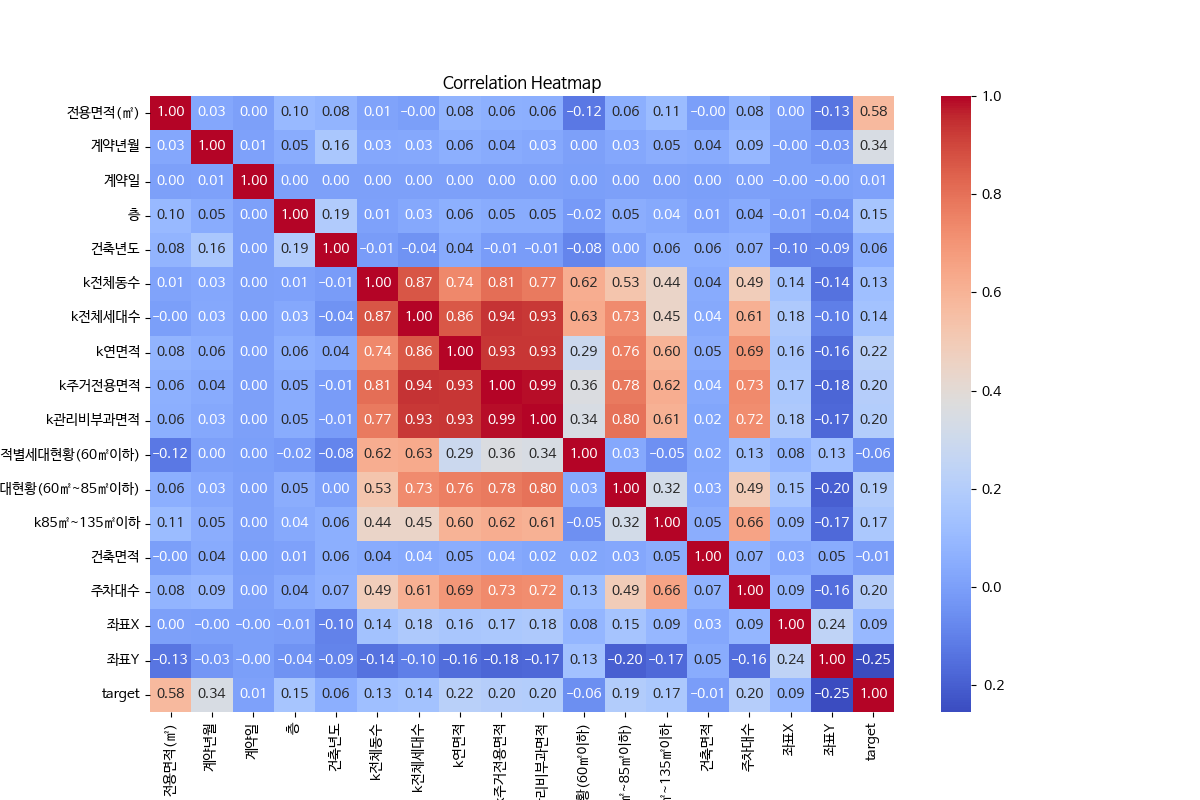

'/data/ephemeral/home/dev/upstageailab5-ml-regression-ml_r4/exports/charts/temp_chart.png'

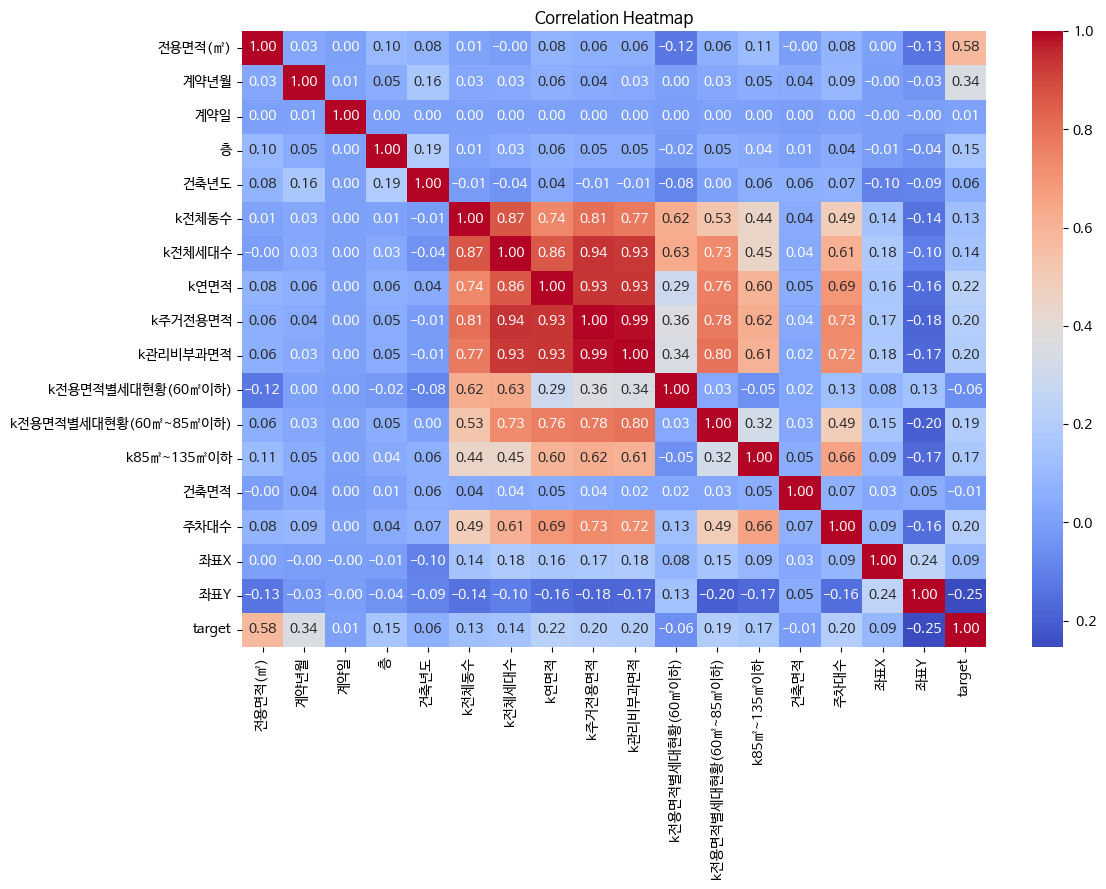

In [14]:
smart_df.chat('Classify Two groups: Categorical or Numeric. Print total number of each group, and each columns. plot basic EDA stuff, based on the sorting (feature importance). Including correlation, heatmap.')

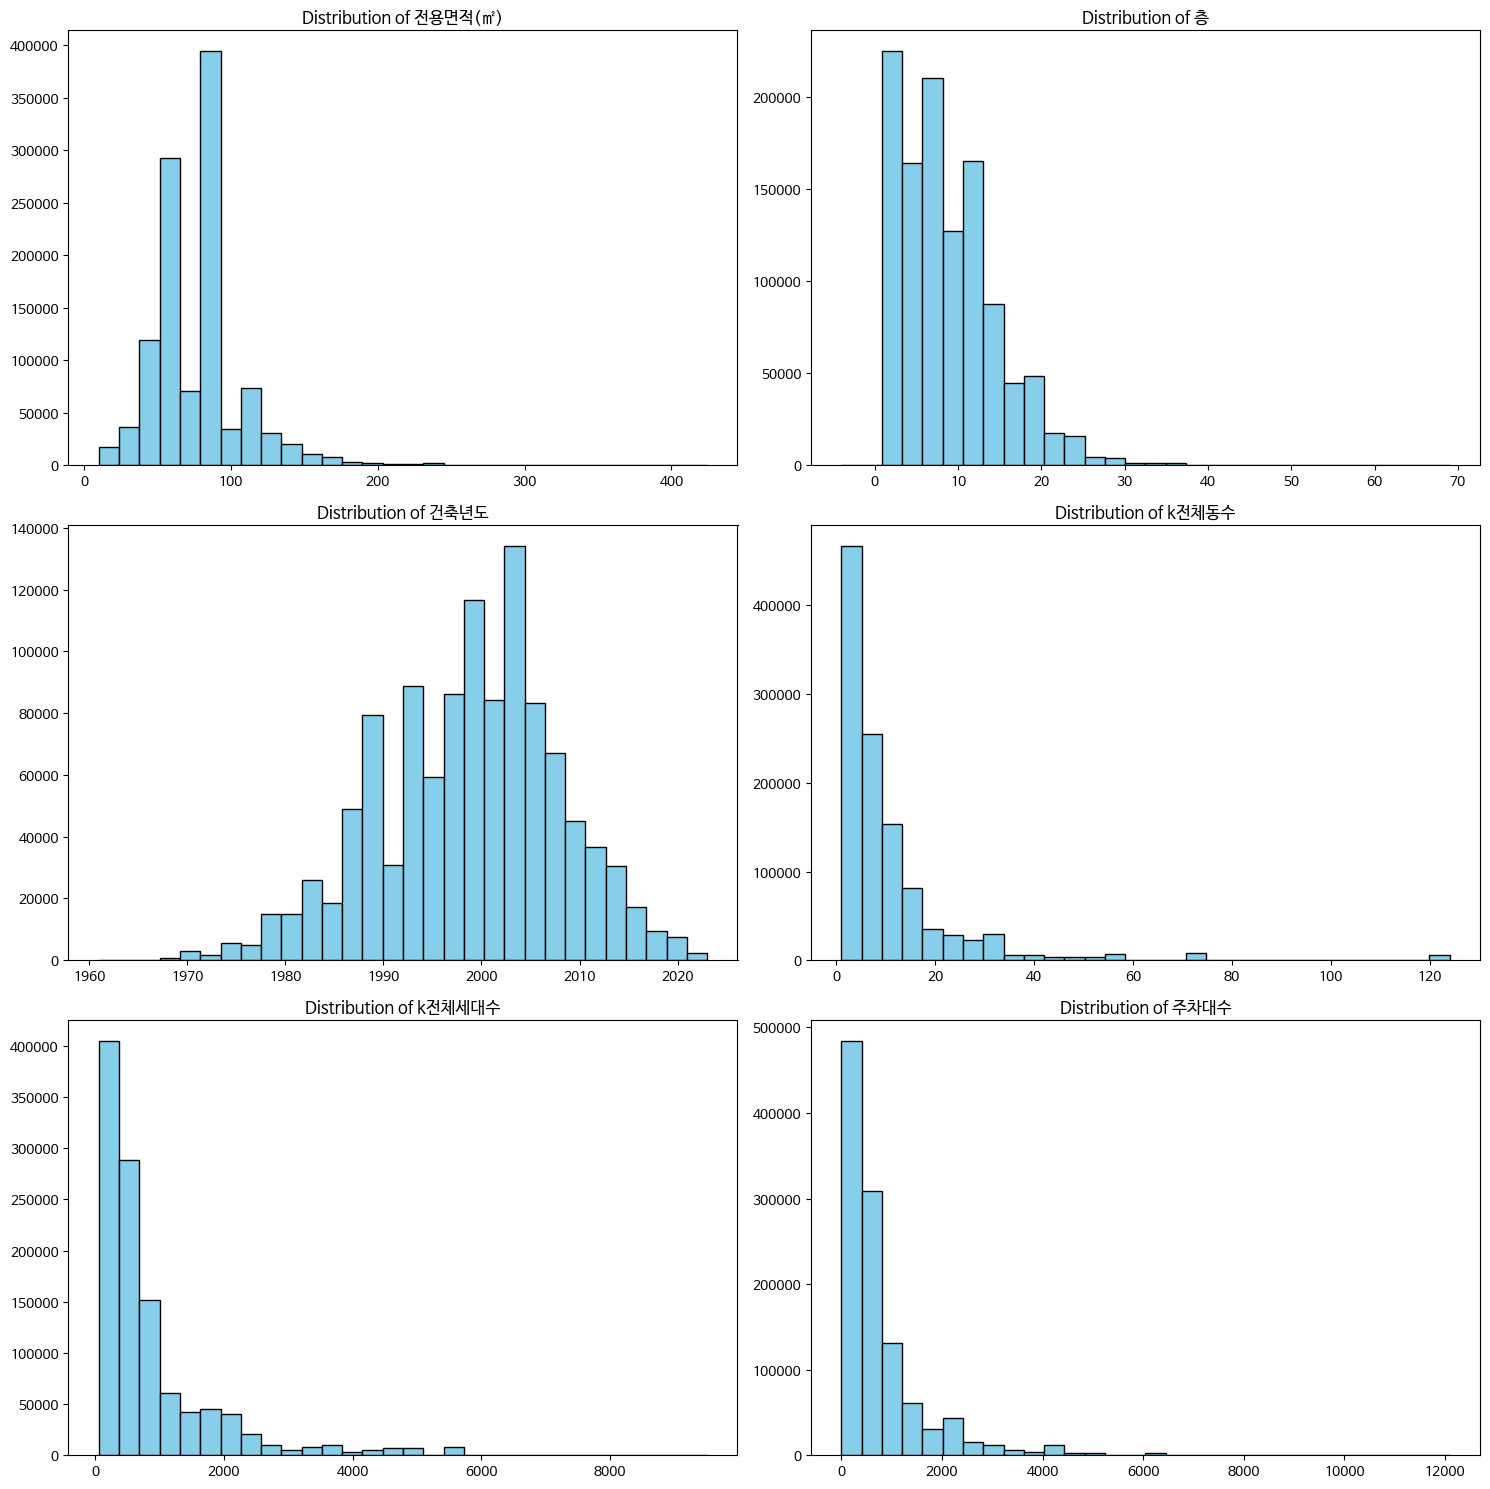

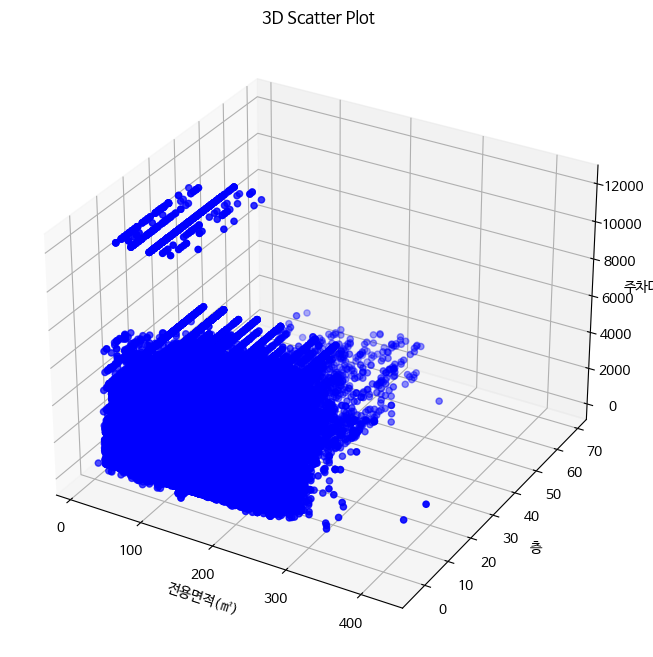

Traceback (most recent call last):
  File "/data/ephemeral/home/miniconda3/envs/ai/lib/python3.9/site-packages/pandasai/pipelines/chat/code_execution.py", line 97, in execute
    raise InvalidOutputValueMismatch(
pandasai.exceptions.InvalidOutputValueMismatch: Value type <class 'str'> must match with type text

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/data/ephemeral/home/miniconda3/envs/ai/lib/python3.9/site-packages/pandasai/pipelines/chat/generate_chat_pipeline.py", line 333, in run
    output = (
  File "/data/ephemeral/home/miniconda3/envs/ai/lib/python3.9/site-packages/pandasai/pipelines/pipeline.py", line 137, in run
    raise e
  File "/data/ephemeral/home/miniconda3/envs/ai/lib/python3.9/site-packages/pandasai/pipelines/pipeline.py", line 101, in run
    step_output = logic.execute(
  File "/data/ephemeral/home/miniconda3/envs/ai/lib/python3.9/site-packages/pandasai/pipelines/chat/code_execution.py", line 1

'Unfortunately, I was not able to answer your question, because of the following error:\n\nGenerated code includes import of mpl_toolkits which is not in whitelist.\n'

In [17]:
smart_df.chat('Select important features, and suggest proper scaling method for each different features, for house price (numerica) prediction problem.')

In [21]:
smart_df.chat('Select important features and tell me why, for house price (numerica) prediction problem.')

Exception in APILogger: <!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8">
<title>Error</title>
</head>
<body>
<pre>PayloadTooLargeError: request entity too large<br> &nbsp; &nbsp;at readStream (/home/ec2-user/domer-ai/express-app/node_modules/raw-body/index.js:156:17)<br> &nbsp; &nbsp;at getRawBody (/home/ec2-user/domer-ai/express-app/node_modules/raw-body/index.js:109:12)<br> &nbsp; &nbsp;at read (/home/ec2-user/domer-ai/express-app/node_modules/body-parser/lib/read.js:79:3)<br> &nbsp; &nbsp;at jsonParser (/home/ec2-user/domer-ai/express-app/node_modules/body-parser/lib/types/json.js:135:5)<br> &nbsp; &nbsp;at Layer.handle [as handle_request] (/home/ec2-user/domer-ai/express-app/node_modules/express/lib/router/layer.js:95:5)<br> &nbsp; &nbsp;at trim_prefix (/home/ec2-user/domer-ai/express-app/node_modules/express/lib/router/index.js:328:13)<br> &nbsp; &nbsp;at /home/ec2-user/domer-ai/express-app/node_modules/express/lib/router/index.js:286:9<br> &nbsp; &nbsp;at Function.p

,전용면적(㎡),층,건축년도,k전체동수,k전체세대수,k건설사(시공사),target
0,79.97,3,1987,8.0,270.0,우성건설,124000
1,79.97,4,1987,8.0,270.0,우성건설,123500
2,54.98,5,1987,8.0,270.0,우성건설,91500
3,79.97,4,1987,8.0,270.0,우성건설,130000
4,79.97,2,1987,8.0,270.0,우성건설,117000
...,...,...,...,...,...,...,...
1118817,59.94,11,1998,4.0,366.0,현대건설,20000
1118818,59.94,10,1998,4.0,366.0,현대건설,20000
1118819,84.83,20,1998,4.0,366.0,현대건설,28000
1118820,84.83,8,1998,4.0,366.0,현대건설,29000


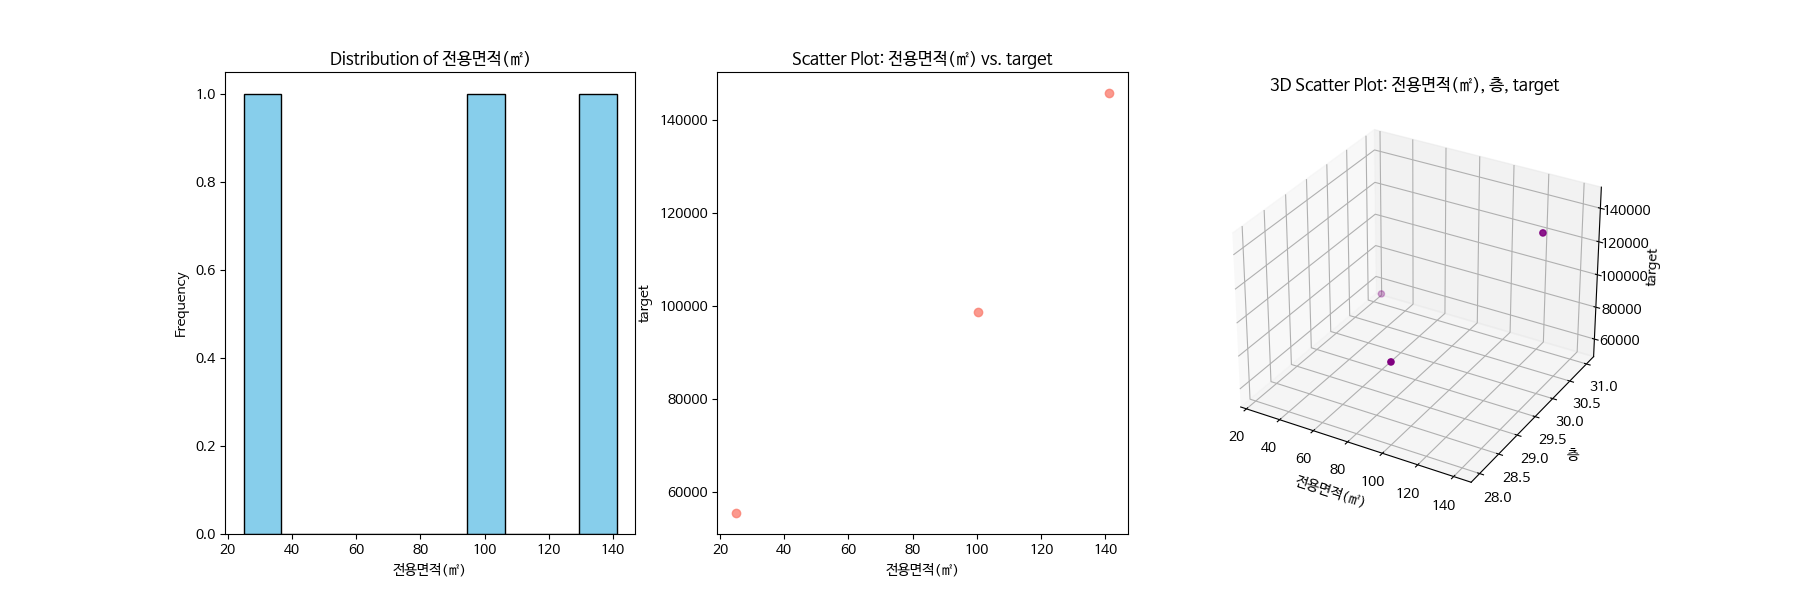

'/data/ephemeral/home/dev/upstageailab5-ml-regression-ml_r4/exports/charts/temp_chart.png'

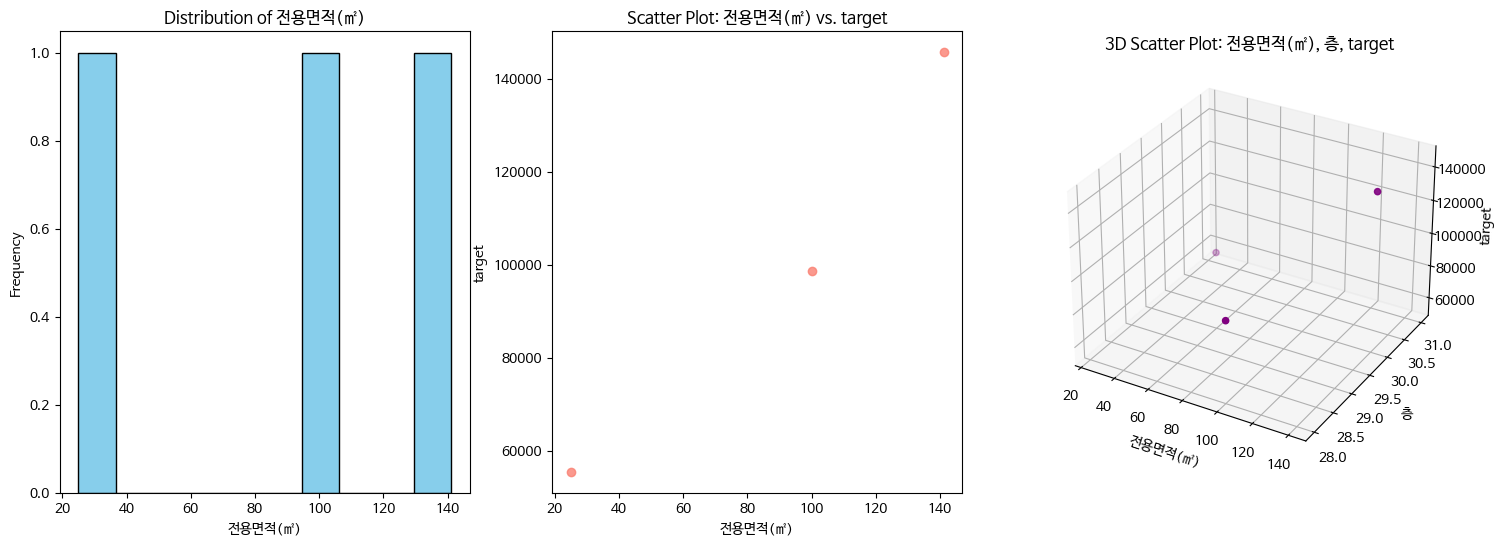

In [16]:
smart_df.chat('Plot distribution and scatter plot altogher. if possible, 3D plot.')

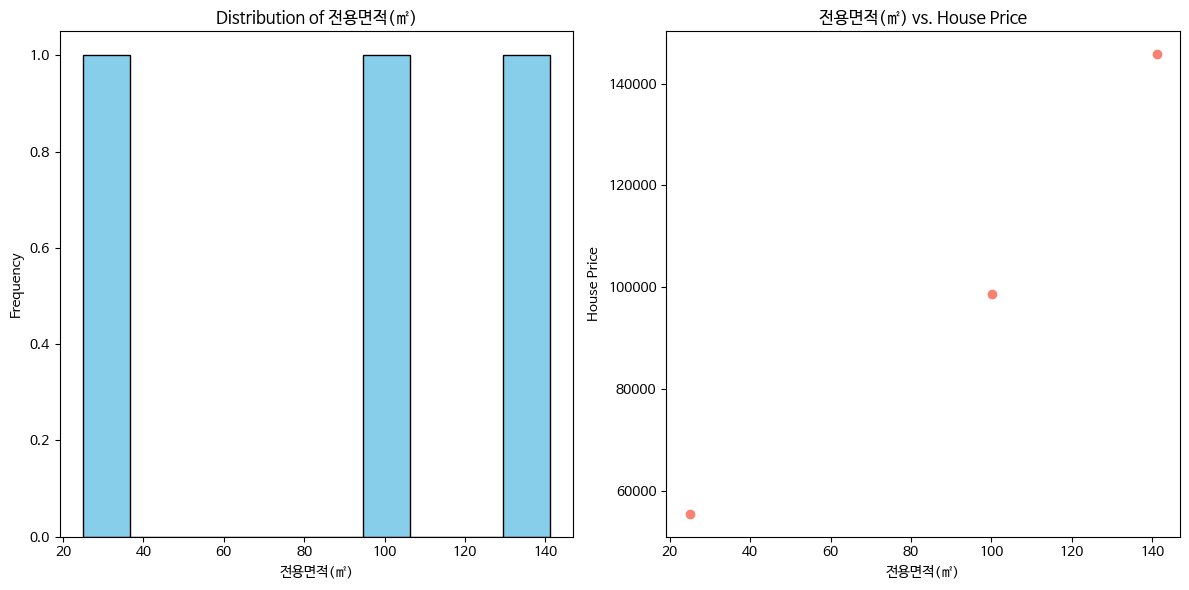

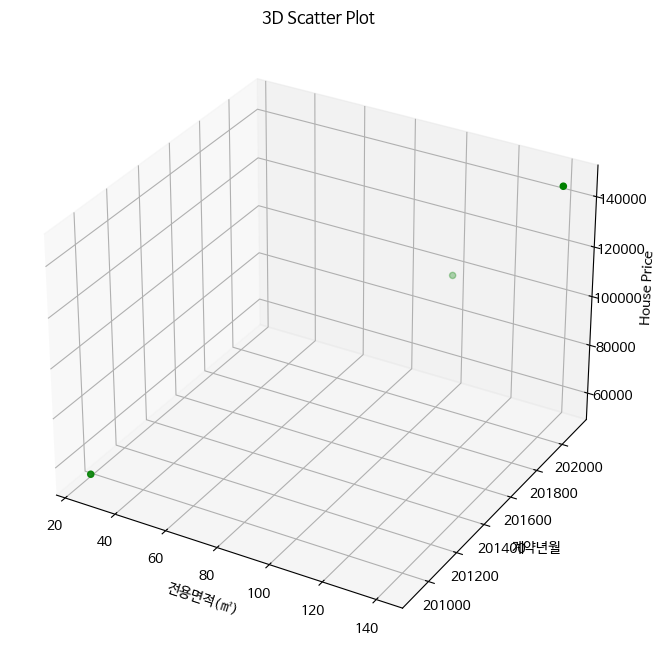

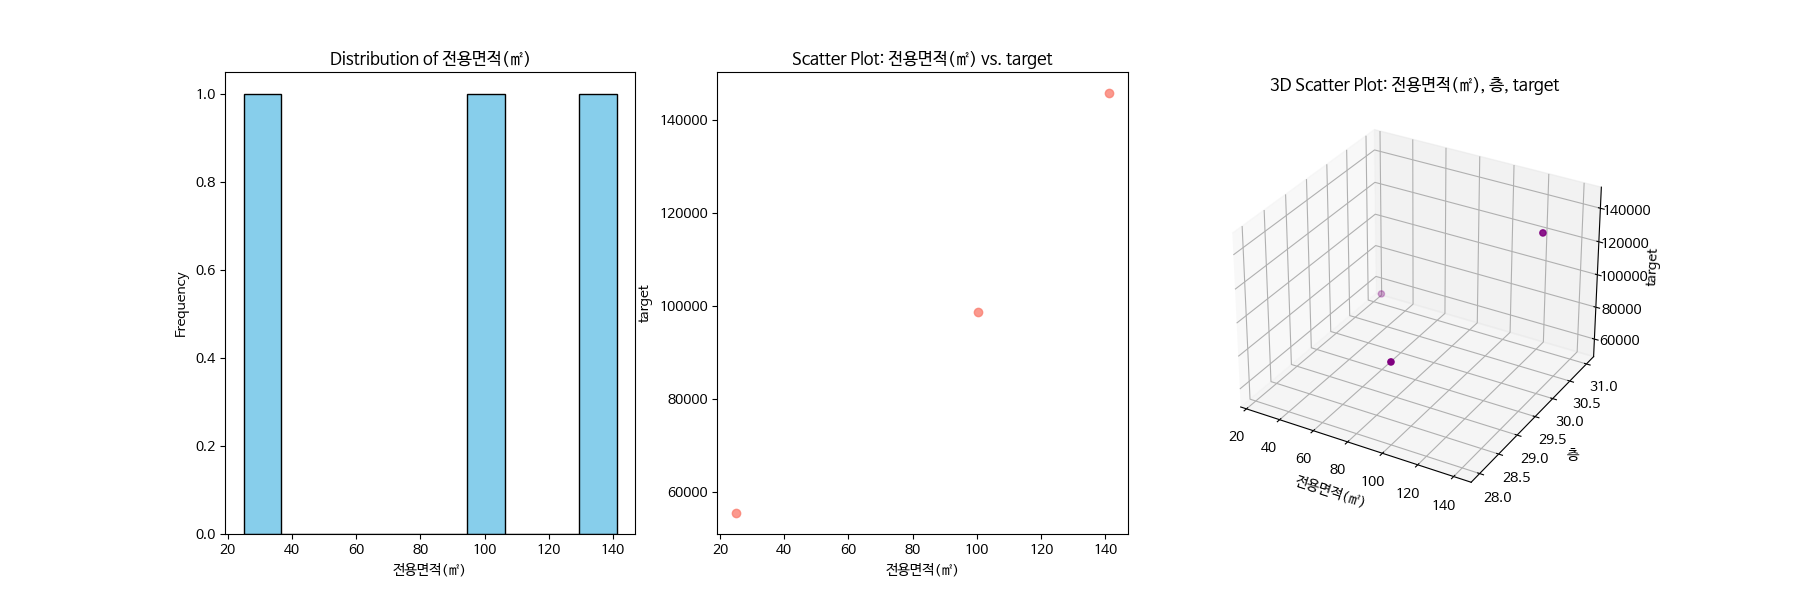

'/data/ephemeral/home/dev/upstageailab5-ml-regression-ml_r4/exports/charts/temp_chart.png'

In [18]:
smart_df.chat('Plot distribution and scatter plot altogher. if possible, 3D plot.')

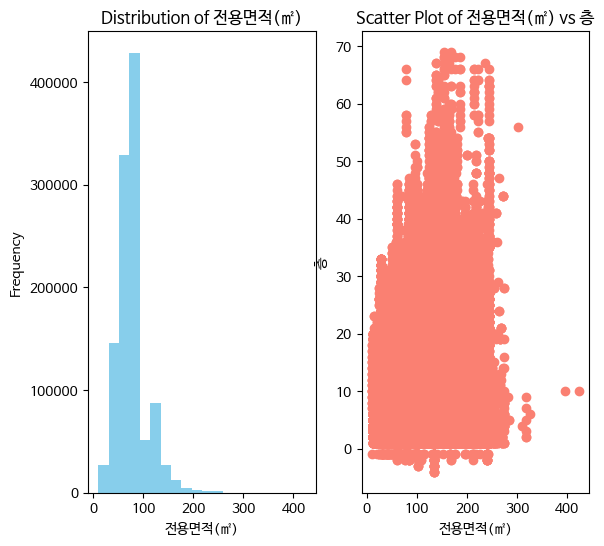

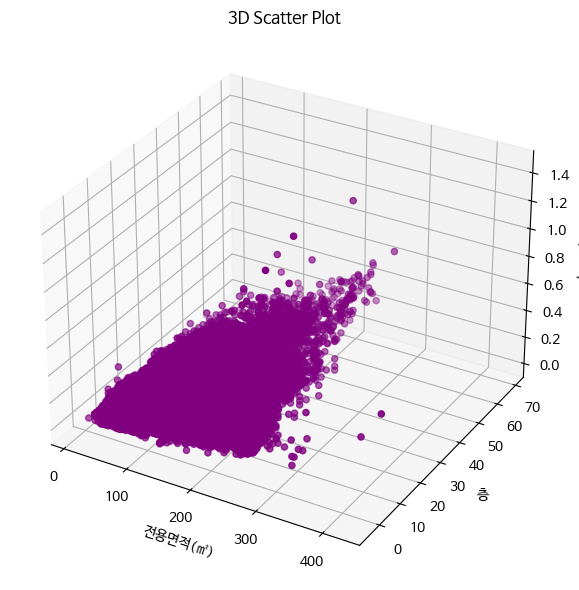

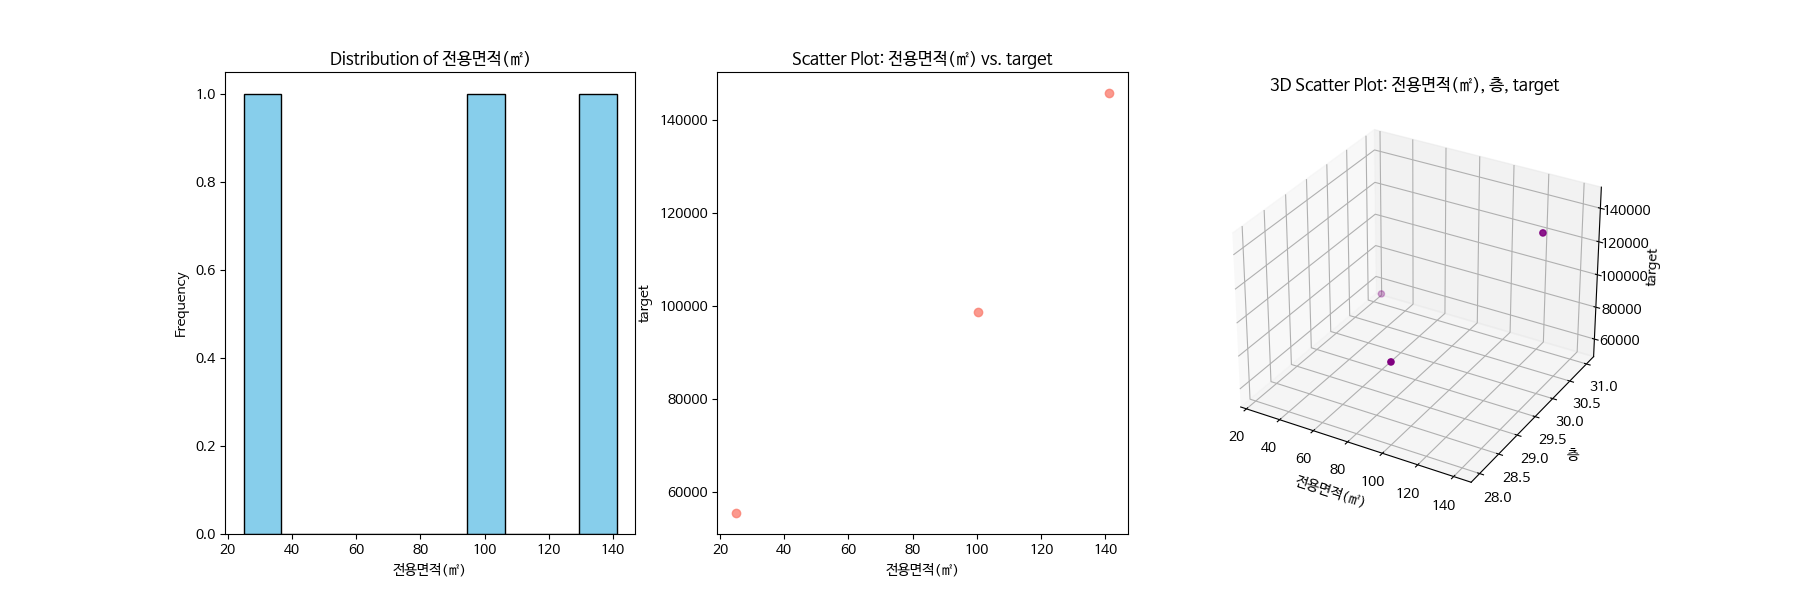

'/data/ephemeral/home/dev/upstageailab5-ml-regression-ml_r4/exports/charts/temp_chart.png'

In [19]:
smart_df.chat('Plot 3 most import figures.')

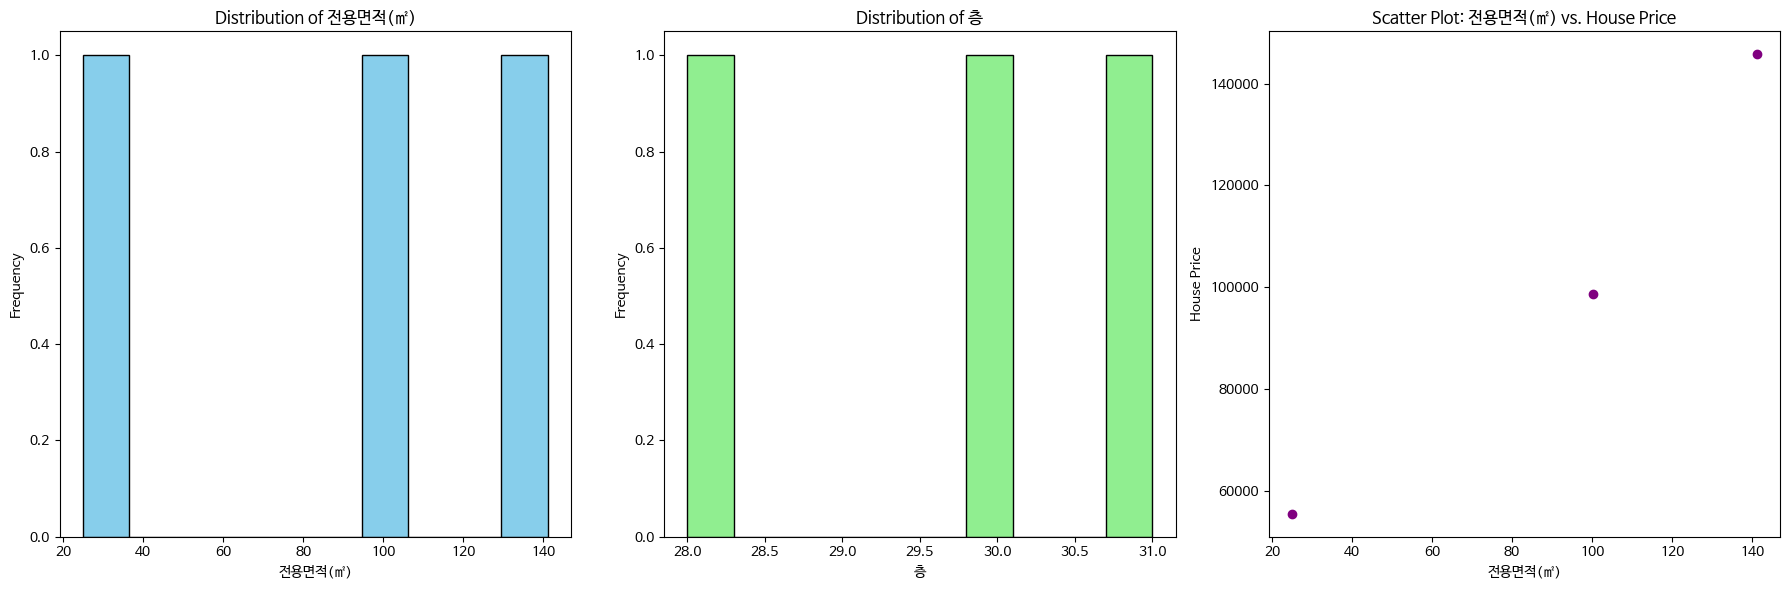

"Min-Max scaling for '전용면적(㎡)' and '층'."

In [20]:
smart_df.chat('What kind of scaling is needed for important features, each?')

In [ ]:
agent = Agent(df)
agent.chat('')



Exception in APILogger: <!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8">
<title>Error</title>
</head>
<body>
<pre>PayloadTooLargeError: request entity too large<br> &nbsp; &nbsp;at readStream (/home/ec2-user/domer-ai/express-app/node_modules/raw-body/index.js:156:17)<br> &nbsp; &nbsp;at getRawBody (/home/ec2-user/domer-ai/express-app/node_modules/raw-body/index.js:109:12)<br> &nbsp; &nbsp;at read (/home/ec2-user/domer-ai/express-app/node_modules/body-parser/lib/read.js:79:3)<br> &nbsp; &nbsp;at jsonParser (/home/ec2-user/domer-ai/express-app/node_modules/body-parser/lib/types/json.js:135:5)<br> &nbsp; &nbsp;at Layer.handle [as handle_request] (/home/ec2-user/domer-ai/express-app/node_modules/express/lib/router/layer.js:95:5)<br> &nbsp; &nbsp;at trim_prefix (/home/ec2-user/domer-ai/express-app/node_modules/express/lib/router/index.js:328:13)<br> &nbsp; &nbsp;at /home/ec2-user/domer-ai/express-app/node_modules/express/lib/router/index.js:286:9<br> &nbsp; &nbsp;at Function.p

,시군구,전용면적(㎡),층,건축년도,도로명,거래유형,k-세대타입(분양형태),k-전체세대수,건축면적,주차대수,단지승인일
0,서울특별시 강남구 개포동,79.97,3,1987,언주로 3,-,분양,270.0,4858.0,262.0,2022-11-17 13:00:29.0
1,서울특별시 강남구 개포동,79.97,4,1987,언주로 3,-,분양,270.0,4858.0,262.0,2022-11-17 13:00:29.0
2,서울특별시 강남구 개포동,54.98,5,1987,언주로 3,-,분양,270.0,4858.0,262.0,2022-11-17 13:00:29.0
3,서울특별시 강남구 개포동,79.97,4,1987,언주로 3,-,분양,270.0,4858.0,262.0,2022-11-17 13:00:29.0
4,서울특별시 강남구 개포동,79.97,2,1987,언주로 3,-,분양,270.0,4858.0,262.0,2022-11-17 13:00:29.0
...,...,...,...,...,...,...,...,...,...,...,...
1118817,서울특별시 은평구 구산동,59.94,11,1998,서오릉로21길 36,-,분양,366.0,0.0,366.0,2013-06-04 16:18:51.0
1118818,서울특별시 은평구 구산동,59.94,10,1998,서오릉로21길 36,-,분양,366.0,0.0,366.0,2013-06-04 16:18:51.0
1118819,서울특별시 은평구 구산동,84.83,20,1998,서오릉로21길 36,-,분양,366.0,0.0,366.0,2013-06-04 16:18:51.0
1118820,서울특별시 은평구 구산동,84.83,8,1998,서오릉로21길 36,-,분양,366.0,0.0,366.0,2013-06-04 16:18:51.0


In [ ]:
agent.chat('Plot the histogram')


In [ ]:

from main_baseline import DataPrep, EDA, FeatureEngineer, Model
# import pygwalker as pyg


data_prep = DataPrep(config)
feat_eng = FeatureEngineer(config)
model_instance = Model(config)
df = data_prep.load_data(base_path)



In [ ]:
df = data_prep.prep_null(df)
df = data_prep.prep_inter(df)
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
cols = ['계약년', '전용면적', '강남여부', '구', '건축년도', '좌표X', '좌표Y', '동']
df = data_prep.remove_outliers_iqr(df, '전용면적')
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(df.shape)
df['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

In [7]:

walker = pyg.walk(
    df,
    spec="./chart_meta_0.json",    # this json file will save your chart state, you need to click save button in ui mannual when you finish a chart, 'autosave' will be supported in the future.
    kernel_computation=True,          # set `kernel_computation=True`, pygwalker will use duckdb as computing engine, it support you explore bigger dataset(<=100GB).
)

Box(children=(HTML(value='\n<div id="ifr-pyg-00062641873d8288WCgihcTGrbe87ADU" style="height: auto">\n    <hea…

In [ ]:

#### Feat eng
df = feat_eng.prep_feat(df)
df_coor = {'x': '좌표X', 'y': '좌표Y'}
df_subway = data_prep.load_feat_data(os.path.join(base_path, 'data','subway_feature.csv'))
df_bus = data_prep.load_feat_data(os.path.joing(base_path, 'data','bus_feature.csv'))
subway_coor = {'x': '위도', 'y': '경도'}
bus_coor = {'x': 'X좌표', 'y': 'Y좌표'}

df = feat_eng.sum_distances_from_a_to_b(df, df_coor , df_subway, subway_coor, 'subway')
df = feat_eng.sum_distances_from_a_to_b(df, df_coor , df_bus, bus_coor, 'bus')
### split
dt_train, dt_test, continuous_columns_v2, categorical_columns_v2 = feat_eng.split_train_test(df)
dt_train, label_encoders = feat_eng.encode_label(dt_train, dt_test, continuous_columns_v2, categorical_columns_v2)
X_train, X_val, y_train, y_val = feat_eng.split_dataset(dt_train)

prep_data = {'X_train': X_train,
            'X_val': X_val,
            'y_train': y_train,
            'y_val': y_val,
            'continuous_columns': continuous_columns_v2,
            'categorical_columns': categorical_columns_v2
}
out_path_data = model_instance.save_data(prep_data)
# loaded_data = load_data_pkl(out_path_data)
# print(loaded_data)
model, pred = model_instance.model_train(X_train, X_val, y_train, y_val)
feat_eng.select_var(model, X_val, y_val, pred, label_encoders, categorical_columns_v2)
model_instance.inference(dt_test)